# E-commerce Data Preparation& Customer Segmentation

**Project Overview**
as the growth of global e-commerce retailer data. We know that data is fragmented, and came across different database or files. **This project was made to address the step of unifying data**

For this project i have three goals i want to achive:
1. **Data Unification** : Create a single, clean, analytical fact table.
2. **Customer Segmentation** : Segment customers into clear value tiers (Gold, Silver, Bronze), based on Monetary Value for highly targeted marketing.

## ETL (Extract, Transform, Load)

The Extract, Transform, Load (ETL) phase is to clean and integrate three primary data sources: the SQL SalesTransactions table and two CSV files (Product Catalog and Customer Info)

Data Idea Source: https://archive.ics.uci.edu/dataset/502/online+retail+ii

### Extract

We load the data from its source system. For this project: the SQL data, and the external data loaded from the uploaded CSVs

In [1]:
import os
import requests
import pandas as pd
import numpy as np

#### Load Data Sources

In [ ]:
from utils.load_db import get_mysql_conn

# Try make connection to mysql server
try:
    conn = get_mysql_conn()
    if conn.is_connected():
        print("Connection Complete!")
    else:
        print("Connection Incomplete!")

except mysql.connection.Error as err:
    print(f"Connection Failed Erro{err}")

Connection Complete!


In [ ]:
from utils.load_db import get_conn_string

conn_str = get_conn_string() 

%load_ext sql
%sql $conn_str

%config SqlMagic.autopandas = True
%config SqlMagic.style = "_DEPRECATED_DEFAULT"
%config SqlMagic.displaycon = False

In [4]:
%%sql salesTransaction << 
SELECT 
    Invoice,
    InvoiceDate,
    CustomerID,
    StockCode,
    Quantity
FROM SalesTransactions
WHERE InvoiceDate >= '2024-11-01' AND InvoiceDate < '2025-11-01'
ORDER BY InvoiceDate;

4948 rows affected.
Returning data to local variable salesTransaction


In [5]:
salesTransaction.head()

,Invoice,InvoiceDate,CustomerID,StockCode,Quantity
0,INV8765,2024-11-04,87321,30987BI,73
1,INV5432,2024-11-04,15093,56321AA,22
2,INV3456,2024-11-04,13767,65432CR,59
3,INV1098,2024-11-04,69213,65432AP,70
4,INV1098,2024-11-04,58567,67890BY,50


In [6]:
def extract_csv(var_name: str, output_fn: str):
    """
    Extract CSV from API to be saved locally.
    """

    url = os.getenv(var_name)
    if not url:
        raise ValueError("URL Not Found or Empty")

    r = requests.get(url)
    r.raise_for_status()

    with open(output_fn, "wb") as f:
        f.write(r.content)

    print(f"Extract CSV Complete {output_fn}")

In [7]:
#extract_csv("PRODUCT_CATALOG_API", "Product Catalog.csv")

In [ ]:
productCatalog = pd.read_csv('../data/Product Catalog.csv')
productCatalog.head()

,StockCode,Description,Category,Price
0,85123A,Red Retrospot Storage Jar,Kitchenware & Dining,26.17
1,71053D,Ceramic Cherry Blossom Mug,Kitchenware & Dining,97.12
2,84406B,Vintage Union Jack Cushion Cover,Home Decor & Furnishings,76.30
3,22045E,Mini Wooden Christmas Tree Decoration,Gifts & Novelty Items,65.93
4,93207F,Set/4 Heart Shaped Coasters,Storage & Organization,86.72


In [9]:
#extract_csv("CUSTOMER_INFO_API", "Customer Info.csv")

In [ ]:
customerInfo = pd.read_csv('../data/Customer Info.csv')
customerInfo.head()

,CustomerID,Country
0,35109,RSA
1,83210,Sweden
2,26710,United Arab Emirates
3,58567,Cyprus
4,29583,Finland


### Transform

On this step we want to enforce business logic and keep the data quality good for future work.

In [11]:
salesTransaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      4948 non-null   object        
 1   InvoiceDate  4948 non-null   datetime64[ns]
 2   CustomerID   4948 non-null   object        
 3   StockCode    4948 non-null   object        
 4   Quantity     4948 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 193.4+ KB


In [12]:
salesTransaction["InvoiceDate"] = pd.to_datetime(salesTransaction["InvoiceDate"]).dt.date

In [13]:
customerInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  100 non-null    int64 
 1   Country     100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [14]:
customerInfo["CustomerID"] = customerInfo["CustomerID"].astype("string")

In [15]:
productCatalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StockCode    100 non-null    object 
 1   Description  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB


In [16]:
data = salesTransaction.merge(customerInfo, on="CustomerID", how="left")\
        .merge(productCatalog, on="StockCode", how="left")

In [17]:
data.head()

,Invoice,InvoiceDate,CustomerID,StockCode,Quantity,Country,Description,Category,Price
0,INV8765,2024-11-04,87321,30987BI,73,NaN,Glass Bell Jar Display Dome,Home Decor & Furnishings,79.53
1,INV5432,2024-11-04,15093,56321AA,22,Saudi Arabia,Knitted Sheep Hot Water Bottle Cover,Unknown Category,6.00
2,INV3456,2024-11-04,13767,65432CR,59,Bahrain,Keep Calm Fridge Magnet Set,Unknown Category,66.16
3,INV1098,2024-11-04,69213,65432AP,70,NaN,Rabbit Design Door Stop,Unknown Category,80.11
4,INV1098,2024-11-04,58567,67890BY,50,Cyprus,Personalised Name Mug,Mugs & Drinkware,56.64


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      6965 non-null   object 
 1   InvoiceDate  6965 non-null   object 
 2   CustomerID   6965 non-null   object 
 3   StockCode    6965 non-null   object 
 4   Quantity     6965 non-null   int64  
 5   Country      4937 non-null   object 
 6   Description  6965 non-null   object 
 7   Category     6965 non-null   object 
 8   Price        6965 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 489.9+ KB


In [19]:
#Filling Country with Unknown and not Country Mode is to ensure data integrity cause we dont want to add more ambiguity
data["Country"] = data["Country"].fillna("Unknown")

In [20]:
#Feature Engineering
data["TotalLine"] = data["Quantity"] * data["Price"]

In [21]:
data.head()

,Invoice,InvoiceDate,CustomerID,StockCode,Quantity,Country,Description,Category,Price,TotalLine
0,INV8765,2024-11-04,87321,30987BI,73,Unknown,Glass Bell Jar Display Dome,Home Decor & Furnishings,79.53,5805.69
1,INV5432,2024-11-04,15093,56321AA,22,Saudi Arabia,Knitted Sheep Hot Water Bottle Cover,Unknown Category,6.00,132.00
2,INV3456,2024-11-04,13767,65432CR,59,Bahrain,Keep Calm Fridge Magnet Set,Unknown Category,66.16,3903.44
3,INV1098,2024-11-04,69213,65432AP,70,Unknown,Rabbit Design Door Stop,Unknown Category,80.11,5607.70
4,INV1098,2024-11-04,58567,67890BY,50,Cyprus,Personalised Name Mug,Mugs & Drinkware,56.64,2832.00


In [22]:
#Reorder Column (This to help when someone else want to work with the data Easy To Read)
def reorder(df, *cols_front):
    cols = list(cols_front) + [c for c in df.columns if c not in cols_front]
    return df[cols]

In [23]:
data = reorder(data, "Invoice", "InvoiceDate", "CustomerID", "Country", "StockCode", "Description", "Category", "Quantity", "Price", "TotalLine")

In [24]:
data.head()

,Invoice,InvoiceDate,CustomerID,Country,StockCode,Description,Category,Quantity,Price,TotalLine
0,INV8765,2024-11-04,87321,Unknown,30987BI,Glass Bell Jar Display Dome,Home Decor & Furnishings,73,79.53,5805.69
1,INV5432,2024-11-04,15093,Saudi Arabia,56321AA,Knitted Sheep Hot Water Bottle Cover,Unknown Category,22,6.00,132.00
2,INV3456,2024-11-04,13767,Bahrain,65432CR,Keep Calm Fridge Magnet Set,Unknown Category,59,66.16,3903.44
3,INV1098,2024-11-04,69213,Unknown,65432AP,Rabbit Design Door Stop,Unknown Category,70,80.11,5607.70
4,INV1098,2024-11-04,58567,Cyprus,67890BY,Personalised Name Mug,Mugs & Drinkware,50,56.64,2832.00


### Load

After Extract, Transform has been done we can saved to be analyze or for modelling later.

In [ ]:
#data.to_csv('ready_to_use_data.csv', index=False)

## Exploratory Data Analysis (EDA)

Analysis where we want to see key performance indicators and highlights critical data quality issues

In [ ]:
data = pd.read_csv("../data/ready_to_use_data.csv")

In [27]:
data.head()

,Invoice,InvoiceDate,CustomerID,Country,StockCode,Description,Category,Quantity,Price,TotalLine
0,INV8765,2024-11-04,87321,Unknown,30987BI,Glass Bell Jar Display Dome,Home Decor & Furnishings,73,79.53,5805.69
1,INV5432,2024-11-04,15093,Saudi Arabia,56321AA,Knitted Sheep Hot Water Bottle Cover,Unknown Category,22,6.00,132.00
2,INV3456,2024-11-04,13767,Bahrain,65432CR,Keep Calm Fridge Magnet Set,Unknown Category,59,66.16,3903.44
3,INV1098,2024-11-04,69213,Unknown,65432AP,Rabbit Design Door Stop,Unknown Category,70,80.11,5607.70
4,INV1098,2024-11-04,58567,Cyprus,67890BY,Personalised Name Mug,Mugs & Drinkware,50,56.64,2832.00


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      6965 non-null   object 
 1   InvoiceDate  6965 non-null   object 
 2   CustomerID   6965 non-null   int64  
 3   Country      6965 non-null   object 
 4   StockCode    6965 non-null   object 
 5   Description  6965 non-null   object 
 6   Category     6965 non-null   object 
 7   Quantity     6965 non-null   int64  
 8   Price        6965 non-null   float64
 9   TotalLine    6965 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 544.3+ KB


In [29]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

#### Overall Sales Trends (Time-Series)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data_monthly = data.copy()
data_monthly["InvoiceDate"] = pd.to_datetime(data_monthly["InvoiceDate"])

data_monthly["year"] = data_monthly["InvoiceDate"].dt.year
data_monthly["month"] = data_monthly["InvoiceDate"].dt.month_name()
data_monthly["month_num"] = data_monthly["InvoiceDate"].dt.month

monthly = (
    data_monthly.groupby(["year", "month", "month_num"])["TotalLine"]
    .sum()
    .reset_index()
    .sort_values(["year", "month_num"])
)

monthly["month_label"] = monthly["month"] + " " + monthly["year"].astype(str)
monthly.drop(['month', 'month_num'], axis=1, inplace=True)

In [32]:
monthly

,year,TotalLine,month_label
1,2024,1113838.44,November 2024
0,2024,1375320.24,December 2024
5,2025,455815.71,January 2025
4,2025,590715.94,February 2025
8,2025,1092101.69,March 2025
2,2025,1075650.43,April 2025
9,2025,697867.24,May 2025
7,2025,349698.55,June 2025
6,2025,259846.53,July 2025
3,2025,791187.89,August 2025


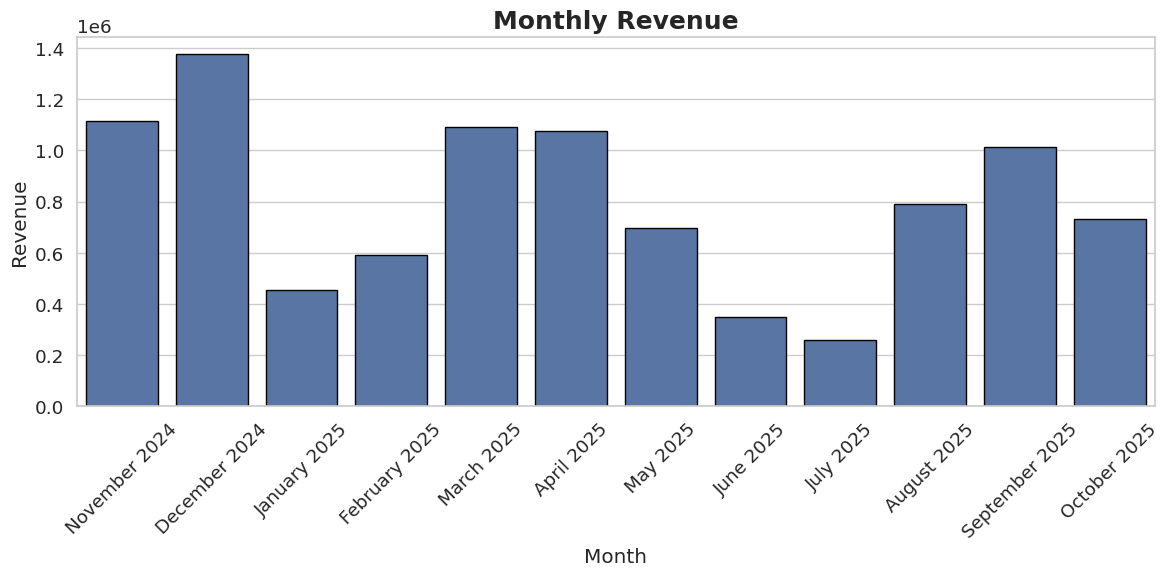

In [33]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12,6))
sns.barplot(data=monthly, x="month_label", y="TotalLine", edgecolor="black")

plt.title("Monthly Revenue", weight="bold", fontsize=18)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Monthly Revenue show us that sales is relatively stable patten, where for seasonality peaking in November through December. This stability is ideal for future forecasting models.

#### Geographic and Product Performance
##### Top 5 Countries by Revenue

In [34]:
data_country = data.copy()

top5_country = (
    data_country.groupby("Country")["TotalLine"]
    .sum()
    .reset_index()
    .sort_values("TotalLine", ascending=False)
    .head(6)
)

In [35]:
top5_country

,Country,TotalLine
36,Unknown,2787821.09
20,Japan,447135.95
27,RSA,366892.63
19,Italy,347926.68
31,Sweden,327341.78
5,Canada,314261.25


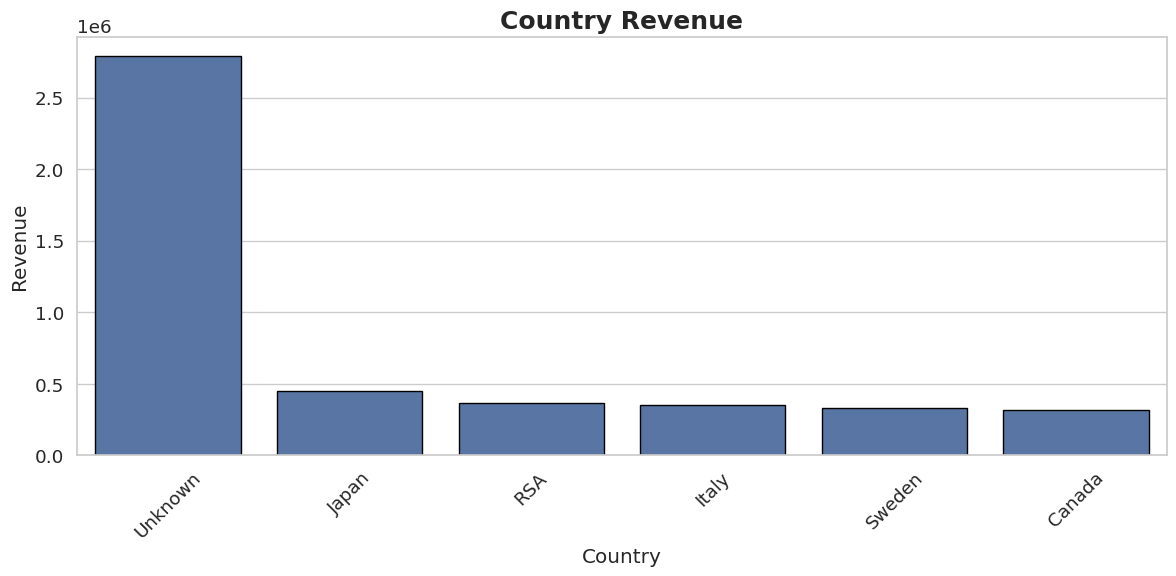

In [36]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12,6))
sns.barplot(data=top5_country, x="Country", y="TotalLine", edgecolor="black")

plt.title("Country Revenue", weight="bold", fontsize=18)
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cause the highest revenue is generated by an "Unknown Country". This can impact the future of analyzing for that what we can do is **re-mapping the Country** but for this problem we would ignore the Unknown Country it self and proceed to top 2-6 country with highest revenue

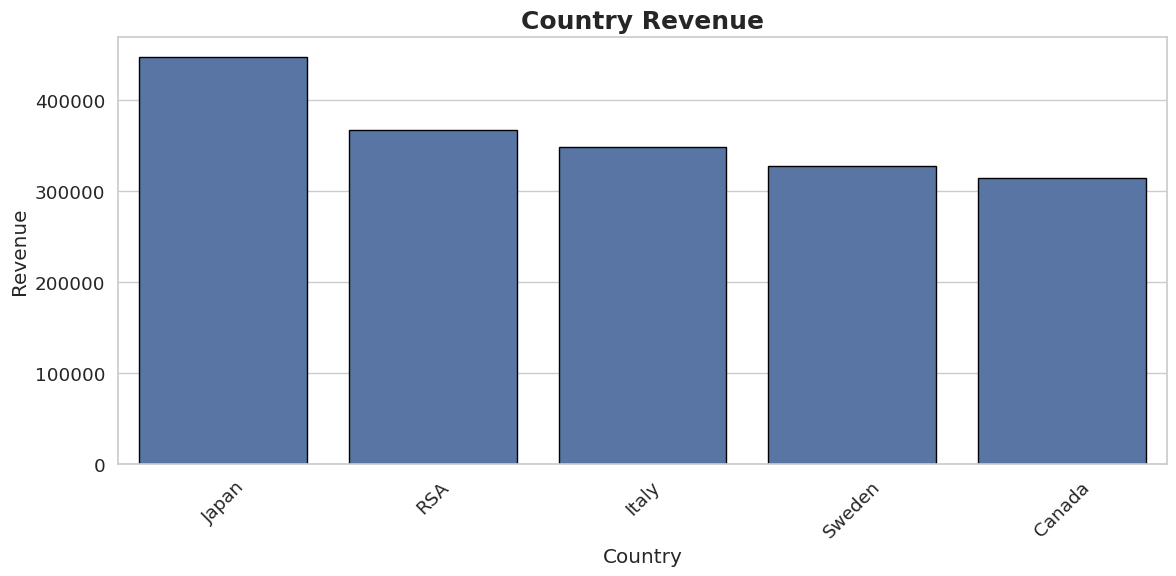

In [37]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12,6))
sns.barplot(data=top5_country[top5_country['Country'] != "Unknown"], x="Country", y="TotalLine", edgecolor="black")

plt.title("Country Revenue", weight="bold", fontsize=18)
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The top 3 markets (Japan, RSA, Italy) with this information we can prioritized for marketing investment and logistics planning. Cause their contribution for revenue is high and would justifies focuesd resource allocation.

##### Top 5 Product Categories by Revenue

In [38]:
data_product = data.copy()

top5_product = (
    data_product.groupby("Category")["TotalLine"]
    .sum()
    .reset_index()
    .sort_values("TotalLine", ascending=False)
    .head(6)
)

In [39]:
top5_product

,Category,TotalLine
15,Unknown Category,2615882.71
3,Home Decor & Furnishings,1186296.17
12,Storage & Organization,1168030.67
2,Gifts & Novelty Items,1007187.97
13,Textiles & Linens,689806.06
6,Kitchenware & Dining,637639.49


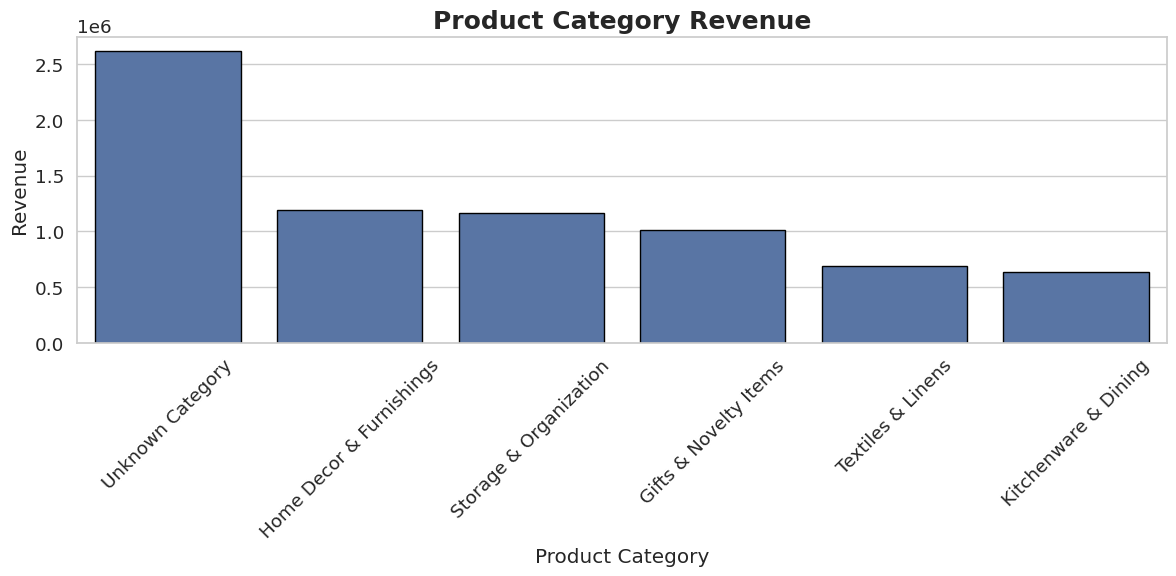

In [40]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12,6))
sns.barplot(data=top5_product, x="Category", y="TotalLine", edgecolor="black")

plt.title("Product Category Revenue", weight="bold", fontsize=18)
plt.xlabel("Product Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Same as Country top 5 revenue, The Highest revenue is generated by an "Unknown Category". So it seems that the mapping of product category at the source need to be fixed but from below Plotting we would find that Home Decor and Storage are the true high-performing categories.

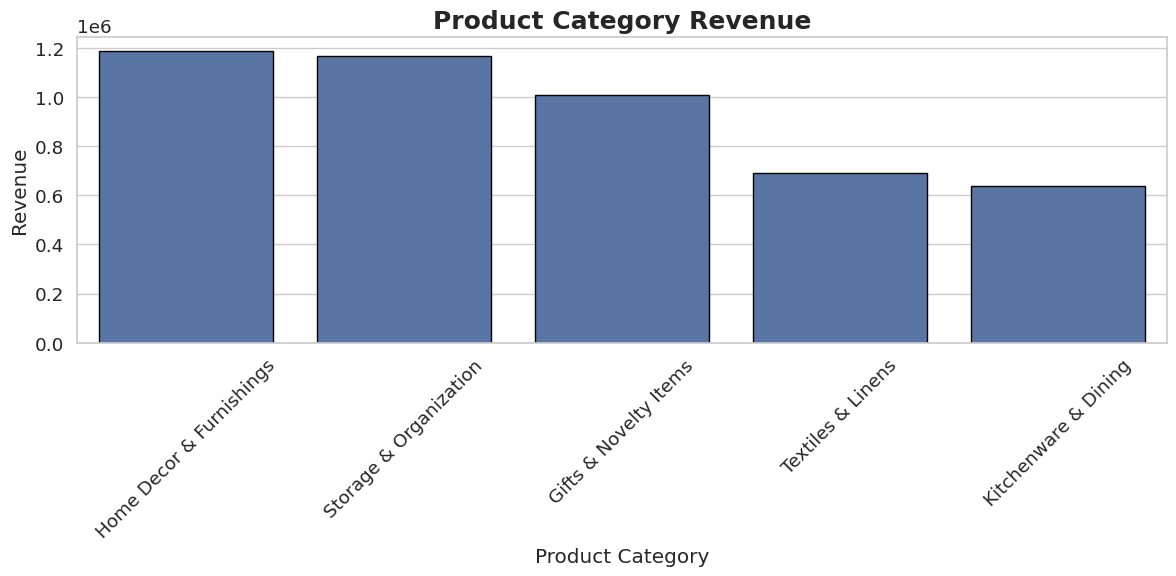

In [41]:
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12,6))
sns.barplot(data=top5_product[top5_product['Category'] != "Unknown Category"], x="Category", y="TotalLine", edgecolor="black")

plt.title("Product Category Revenue", weight="bold", fontsize=18)
plt.xlabel("Product Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Customer Value Tiering

To provide immediate value to the marketing team,segmenting customers into tiers based on a single, would give us powerful metric on their **Monetary Value (Total Spending)** 

In [42]:
#Calculate Monetary Value
monetary = data.groupby('CustomerID')['TotalLine'].sum().reset_index()
monetary.rename(columns={'TotalLine': 'MonetaryValue'}, inplace=True)
monetary.head()

,CustomerID,MonetaryValue
0,12583,140234.36
1,13047,69283.36
2,13767,78948.28
3,14298,77891.88
4,15093,62349.21


In [43]:
#Define Tiers (Top 20% is Gold, 30% for Silver, 50% for Bronze)
tier_80_cutoff = monetary['MonetaryValue'].quantile(0.80)
tier_50_cutoff = monetary['MonetaryValue'].quantile(0.50)

In [44]:
def assign_tier(value):
    if value >= tier_80_cutoff:
        return "Gold"
    elif value >= tier_50_cutoff:
        return "Silver"
    else:
        return "Bronze"

In [45]:
monetary["Tier"] = monetary["MonetaryValue"].apply(assign_tier)
monetary = monetary.sort_values("MonetaryValue", ascending=False)

In [46]:
monetary.head()

,CustomerID,MonetaryValue,Tier
74,83210,311461.04,Gold
7,17404,293885.22,Gold
83,92789,290297.34,Gold
56,65321,251055.45,Gold
17,26710,239542.83,Gold


In [47]:
monetary['Tier'].value_counts()

Tier
Bronze    45
Silver    27
Gold      19
Name: count, dtype: int64

Group Summary

In [48]:
tier_summary = (
    monetary.groupby("Tier")
    .agg(
        Customer_Count = ("CustomerID", "count"),
        Total_Revenue = ("MonetaryValue", "sum")
    )
    .reset_index()
)

tier_summary

,Tier,Customer_Count,Total_Revenue
0,Bronze,45,3079519.51
1,Gold,19,3785789.88
2,Silver,27,2682582.55


Calculate Revenue Share %

In [49]:
total_rev = tier_summary["Total_Revenue"].sum()
tier_summary["Revenue_Share_%"] = np.round(((tier_summary["Total_Revenue"] / total_rev) * 100), 1)

In [50]:
tier_summary = tier_summary.sort_values("Total_Revenue", ascending=False)
tier_summary

,Tier,Customer_Count,Total_Revenue,Revenue_Share_%
1,Gold,19,3785789.88,39.7
0,Bronze,45,3079519.51,32.3
2,Silver,27,2682582.55,28.1


#### Why we want to use Monetary Tiering?
Grouping customers by how much revenue they bring in can helps us treat them differently in a smarter way not just using the same marketing effort for everyone.

For example:
- Gold Tier we can keep them happy. Give special perks, VIP deals, and make sure they stay loyal, this is because the customers spend the most and are the most valuable.
- Silver Tier we could encourage upgrades. Give targeted offers to increase their spend so they move to Gold. We could push these customers to become Gold tier witht he right push.
- Bronze Tier, some of these are low spenders or casual buyers. We could use simple, low-cost marketing and dont overspend resources here.

In simple way, we want to **Keep the big spender**, **Grow the medium spender**, and handle the **low spender efficiently**

#### Extra Visualization

In [51]:
tier_summary_v2 = (
    monetary.groupby("Tier")["MonetaryValue"]
    .sum()
    .reset_index()
)

total_rev = tier_summary_v2["MonetaryValue"].sum()
tier_summary_v2["RevenueShare"] = tier_summary_v2["MonetaryValue"] / total_rev * 100


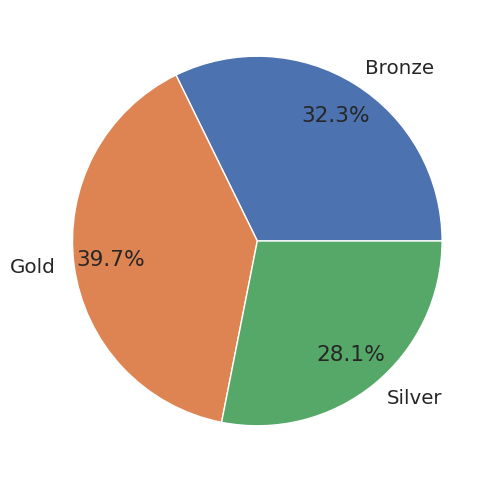

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.3)

fig, ax = plt.subplots(figsize=(6,6))

# pie
wedges, texts, autotexts = ax.pie(
    tier_summary_v2["RevenueShare"],
    labels=tier_summary_v2["Tier"],
    autopct='%1.1f%%',
    pctdistance=0.8
)